In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Definición de constantes y parámetros del problema

In [4]:
c = 299792458.0

f0 = 1e9
er1 = 1
er2 = 16.0
ert = 4.0

eps0 = 8.854e-12
eps1 = 8.854e-12
eps2 = er1 * eps0
epst = np.sqrt(eps1 * eps2)

eta0 = 120 * np.pi
eta1 = eta0 / np.sqrt(er1)  
eta2 = eta0 / np.sqrt(er2)  
etat = eta0 / np.sqrt(ert)

# Lambda en la lámina a f0
lambda_m0 = c / (f0 * np.sqrt(epst / eps0))

# Espesor de la lámina (cuarto de onda)
d = lambda_m0 / 4


# Parte a

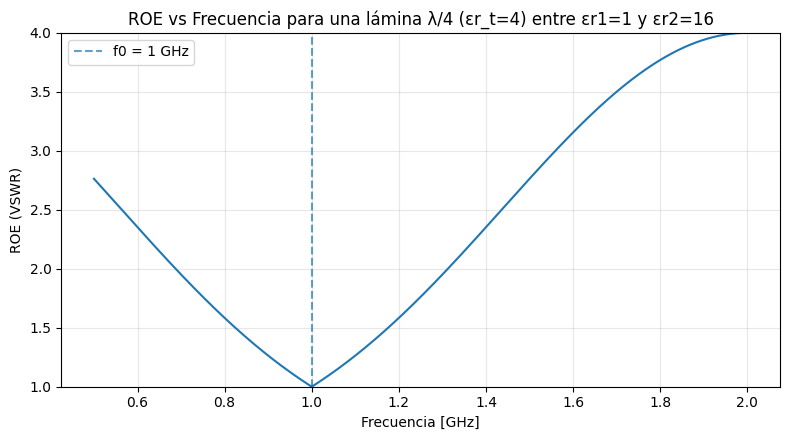

In [5]:
f = np.linspace(f0/2, 2*f0, 2001) 

beta_d = (np.pi/2.0) * (f / f0)
tan_bd = np.tan(beta_d)

Zin = etat * (eta2 + 1j * etat * tan_bd) / (etat + 1j * eta2 * tan_bd)

Gamma = (Zin - eta1) / (Zin + eta1)

ROE = (1 + np.abs(Gamma)) / (1 - np.abs(Gamma))

# Graficar ROE vs frecuencia
plt.figure(figsize=(8, 4.5))
plt.plot(f/1e9, ROE)
plt.axvline(f0/1e9, linestyle='--', alpha=0.7, label='f0 = 1 GHz')
plt.ylim(1, min(5, np.nanmax(ROE)))   
plt.xlabel('Frecuencia [GHz]')
plt.ylabel('ROE (VSWR)')
plt.title('ROE vs Frecuencia para una lámina λ/4 (εr_t=4) entre εr1=1 y εr2=16')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



# Parte b